# DATA-614 Final Project: Classifying Rock / Paper / Scissors

| University | Class | Student |
| ---------- | ----- | ---------- |
| Franklin University | 23/SU-DATA-612-Q1WW Online | [Matt Eland](https://MattEland.dev) (ID: 0771584) |

Code developed using VS Code and Jupyter Notebooks running on Anaconda and Python 3.9.12

---

## Project Overview

### Overall Approach

### Data Sources

#### Rock / Paper / Scissors Images Dataset

#### Rock / Paper / Scissors Game Moves Dataset

### Technologies Used

- **Python**
- **Pandas**
- **Plotly**
- **OpenCV**
- **SciKit Learn**

In [1]:
# Anaconda doesn't come with OpenCV by default, so install the headless version
!pip install opencv-python-headless

In [54]:
import cv2
import numpy as np
import os
import urllib.request
import shutil
import time
import random
import pandas as pd
from IPython.display import display, Image
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV

## Download & Extract the Training Data

Since the images involved in training are too big to fit into source control, this notebook will download a zip file from Kaggle if one doesn't exist locally and then unzip it into the proper directories

This is the dataset from [https://www.kaggle.com/datasets/sanikamal/rock-paper-scissors-dataset](https://www.kaggle.com/datasets/sanikamal/rock-paper-scissors-dataset?resource=download), however because Kaggle requires authentication to download it's easier to re-upload it to [Azure Blob Storage](https://franklinuniversity.blob.core.windows.net/data614/RPSDataSet.zip) with open access enabled and download it from there.

In [2]:
zip_url = 'https://franklinuniversity.blob.core.windows.net/data614/RPSDataSet.zip'
zip_file = 'RPSDataSet.zip'
extract_dir = 'dataset'

In [4]:
# The dataset for this project is around 3000 images, all of very high resolutions
# Because git doesn't normally do well with large files, I'm excluding images and zip files from git
# and instead the application must download the zip and then extract it.
# Since Kaggle requires authentication to download things, I'm using Azure Blob Storage to host the zip file instead

# If we don't have a dataset, we'll need to download and extract it
if not os.path.exists(extract_dir):
    # If we haven't downloaded the zip file, do so
    if not os.path.exists(zip_file):
        print('Downloading data from', zip_url, 'this will take awhile...')
        path, _ = urllib.request.urlretrieve(zip_url, zip_file)
        print('Downloaded', path)
    else:
        print(zip_file, 'already exists')

    print()

    # We know we don't have the directory, so extract the zip file now
    print('Extracting', zip_file)
    shutil.unpack_archive(zip_file, extract_dir)
    print('Extracted', zip_file, 'to folder:', extract_dir)
else:
    print(extract_dir, 'already exists')

Downloaded RPSDataSet.zip

Extracting RPSDataSet.zip
Extracted RPSDataSet.zip to folder: dataset


## Image Data Loading

In [13]:
# This is a common processing function that will be applied to images in the dataset as well as images from the webcam
def process_image(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Resize the image to 100x100 pixels
    return cv2.resize(gray, (100, 100))

# The processing logic for the training vs validation images looks identical, so put it in a function
def load_data_and_labels(path):
    # Create empty lists to store the data and labels
    data = []
    labels = []

    # Loop through each subfolder in the folder
    for folder_name in ['rock', 'paper', 'scissors']:
        folder_path = os.path.join(path, folder_name)

        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)

            # Load and process the image
            image = cv2.imread(image_path)
            image = process_image(image)

            # Store the image in flattened format
            data.append(image.flatten())
            
            # All images are stored in directories of 'rock', 'paper', and 'scissors'
            # These directory names will be used as the labels
            labels.append(folder_name)

    # Convert to arrays
    data = np.array(data)
    labels = np.array(labels)

    # Normalize the pixel data
    scaler = StandardScaler()
    data = scaler.fit_transform(data)

    return data, labels

def load_data_and_labels_from_rps_images(subdirectory, purpose):
    # Define the path to the training images folder
    path = extract_dir + '/' + 'Rock-Paper-Scissors/' + subdirectory
    print('Reading', purpose, 'images from', path)

    # Load the training dataset (images)
    training_data, labels = load_data_and_labels(path)

    print('Loaded {} {} images'.format(len(training_data), purpose))
    print()
    
    return training_data, labels

In [14]:
# Load the training and test data
training_data, training_labels = load_data_and_labels_from_rps_images('train', 'training')
test_data, test_labels = load_data_and_labels_from_rps_images('test', 'test')

Reading training images from dataset/Rock-Paper-Scissors/train
Loaded 2520 training images

Reading test images from dataset/Rock-Paper-Scissors/test
Loaded 372 test images



## Training a Model

In [20]:
print('Fitting model to training data. This will take a little bit...')
print()

# Best observed parameters from grid search {'activation': 'logistic', 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'max_iter': 100, 'solver': 'adam'}
# A simple fit to train a baseline version of the model. We'll do something better shortly with a grid search
model = MLPClassifier(activation='logistic', hidden_layer_sizes=(50, 50), learning_rate='constant', max_iter=100, solver='adam', random_state=42)
model.fit(training_data, training_labels)

print('Trained', model)

Fitting model to training data. This will take a little bit...

Trained MLPClassifier(activation='logistic', hidden_layer_sizes=(50, 50), max_iter=100,
              random_state=42)


In [21]:
def evaluate_model_performance(model, test_data, test_labels):
    # Classify the test data so we can grade the accuracy and other metric
    predicted_labels = model.predict(test_data)

    # Print high level metrics of note
    print('F1 Score: {:.2f}'.format(f1_score(test_labels, predicted_labels, average='weighted')))
    print('Accuracy: {:.2f}'.format(accuracy_score(test_labels, predicted_labels)))
    print('Recall: {:.2f}'.format(recall_score(test_labels, predicted_labels, average='weighted')))
    print('Precision: {:.2f}'.format(precision_score(test_labels, predicted_labels, average='weighted')))
    print()

    # Display per-class metrics
    print(classification_report(test_labels, predicted_labels))

    # Display a confusion matrix with raw number counts
    plot_confusion_matrix(model, test_data, test_labels, display_labels=['rock', 'paper', 'scissors'], cmap='Purples')

F1 Score: 0.67
Accuracy: 0.67
Recall: 0.67
Precision: 0.67

              precision    recall  f1-score   support

       paper       0.65      0.59      0.62       124
        rock       0.60      0.68      0.63       124
    scissors       0.78      0.74      0.76       124

    accuracy                           0.67       372
   macro avg       0.67      0.67      0.67       372
weighted avg       0.67      0.67      0.67       372



c:\Users\Admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


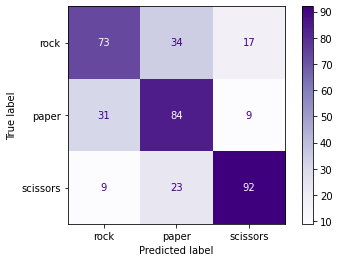

In [22]:
# Evaluate the performance of our initial model
evaluate_model_performance(model, test_data, test_labels)

In [25]:
# Tuning the model with grid search to find an optimal set of hyperparameters
# Source: https://medium.com/@eymericplaisant/tuning-the-mlpclassifier-in-scikit-learn-to-outperform-classic-models-437b80d7687c

def find_best_model_with_grid_search(model):
    # define the range of values for each parameter
    param_grid = {
        'hidden_layer_sizes': [(100,), (50, 50), (100, 50, 25)],
        'activation': ['relu', 'tanh', 'logistic', 'identity'],
        'solver': ['adam', 'lbfgs', 'sgd'],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
        'max_iter': [100, 500, 1000]
    }

    print('Finding best model with grid search. This is going to take a few hours...')

    # create a grid search model
    grid_search = GridSearchCV(model, param_grid, cv=2, n_jobs=-1, verbose=1)
    grid_search.fit(training_data, training_labels)

    #print the best parameters and accuracy
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Accuracy: {grid_search.best_score_:.2f}")

    # Evaluate the performance of our best model
    evaluate_model_performance(grid_search.best_estimator_, test_data, test_labels)

    return grid_search.best_estimator_

In [27]:
# This will take a lot of time, but if you want to do it, it may improve the model
should_use_grid_search = False

if should_use_grid_search:
    model = find_best_model_with_grid_search(model)
    evaluate_model_performance(model, test_data, test_labels)
else:
    print('Skipping grid search. We don\'t have that kind of time!')

Skipping grid search. We don't have that kind of time!


## Testing the trained image classification model

In [29]:
def display_image(cv2Image):
    # Encode the image as a PNG so display can handle it and get the second value which has the image data
    display(Image(data=cv2.imencode('.png', cv2Image)[1]))
    
def display_prediction(label, confidences):
    print(f'Classifying as {label}')
    print(f'Paper Confidence: {confidences[0] * 100} %')
    print(f'Rock Confidence: {confidences[1] * 100} %')
    print(f'Scissors Confidence: {confidences[2] * 100} %')

def predict_image(image):
    # Flatten the image into a 1D array
    prediction_data = [image.flatten()]

    # Generate predictions and probabilities
    label = model.predict(prediction_data)
    confidence = model.predict_proba(prediction_data)

    return label[0], confidence[0]


def classify_image(image):
    # Process the image into a standardized form
    image = process_image(image)
    display_image(image)

    # Generate predictions and probabilities
    label, confidences = predict_image(image)
    display_prediction(label, confidences)
    return label

def classify_disk_image(filename):
    # Load and display the original image
    image = cv2.imread(filename)
    display_image(image)
    
    return classify_image(image)

### Test Case

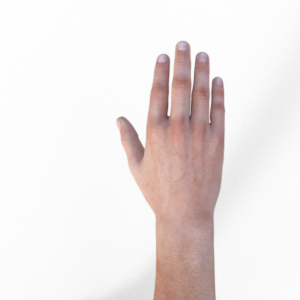

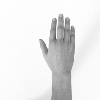

Classifying as paper
Paper Confidence: 63.38209680092641 %
Rock Confidence: 12.526559067811242 %
Scissors Confidence: 24.09134413126234 %

Classified test image as paper


In [46]:
label = classify_disk_image('dataset/Rock-Paper-Scissors/test/paper/testpaper03-12.png')

print()
print('Classified test image as', label)

## Webcam Processing

Successful read from camera 0 960.0x540.0


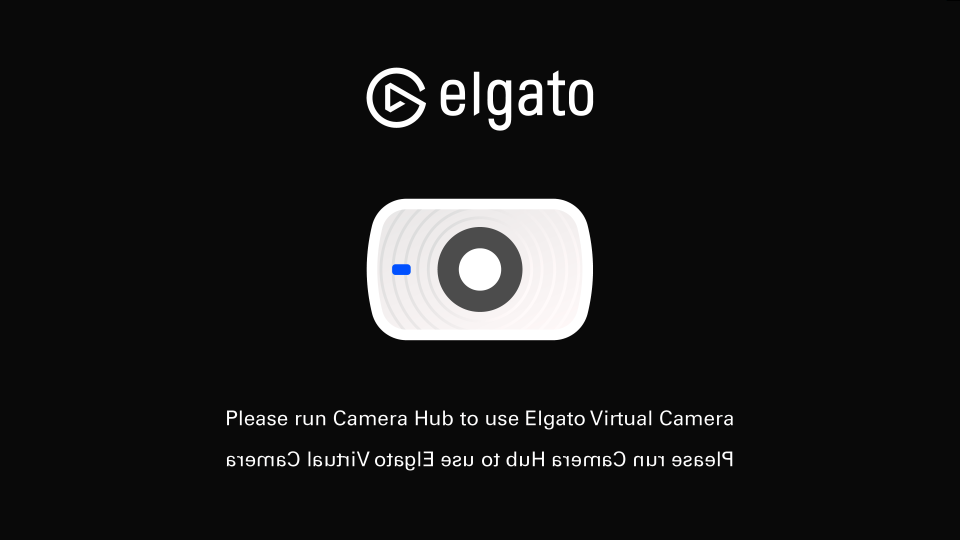

Successful read from camera 2 640.0x480.0


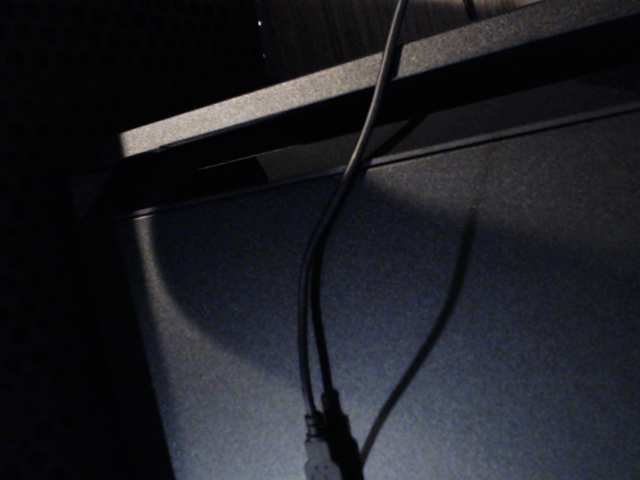

Using camera 2


In [55]:
video_index = -1

# Open CV doesn't tell us much about the video capture devices, so we need to try and see what works
for i in range(5):
    # Try to open the video device
    cap = cv2.VideoCapture(i)
    
    # Check if the video device was successfully opened
    if cap.isOpened():
        # Get the name of the video device for diagnostics
        dimensions = f'{cap.get(cv2.CAP_PROP_FRAME_WIDTH)}x{cap.get(cv2.CAP_PROP_FRAME_HEIGHT)}'
        
        # Get a single image frame to test
        successful_read, frame = cap.read()

        # If we got an image, assume this is a good camera and update our index
        if successful_read:
            print('Successful read from camera', i, dimensions)
            display_image(frame)
            video_index = i
        else:
            print('Failed to read from camera', i, dimensions)
        
    # Release the video device
    cap.release()

# Validate the camera
if video_index >= 0:
    print('Using camera', video_index)
else:
    print('No camera found. This notebook requires a webcam for full functionality')

# Now that we know the correct webcam to use, create a function around that index

def get_image_from_camera():
    cap = cv2.VideoCapture(video_index)

    # Get a single image frame
    _, frame = cap.read()

    # Release the camera
    cap.release()

    # Provide the image as the function result
    return frame

## Simulating Rock Paper Scissors

### Loading Historical Game Info

In [56]:
history_file = 'game_history.csv'
min_moves_for_learning = 5

def create_empty_history():
    df = pd.DataFrame(columns=['t_minus_1_player_move', 't_minus_1_winner', 't_minus_2_player_move', 't_minus_2_winner', 'next_move'])
    df.to_csv(history_file, index=False)
    return df

def load_game_history():
    if not os.path.exists(history_file):
        print('No historical data found. Creating file and starting from scratch.')
        df = create_empty_history()
    else:
        df = pd.read_csv(history_file)
        print('Loaded historical move data containing', df.shape[0], 'moves.')
    
    if df.shape[0] < min_moves_for_learning:
        print('Not enough historical data found. The first', min_moves_for_learning - df.shape[0], 'moves will be random.')

    return df

df_history = load_game_history()
df_history.head()

No historical data found. Creating file and starting from scratch.
Not enough historical data found. The first 5 moves will be random.


,t_minus_1_player_move,t_minus_1_winner,t_minus_2_player_move,t_minus_2_winner,next_move


### Storing Player Moves

In [ ]:
# T-1 is the last move the player made
t_minus_1_move = None
t_minus_1_winner = None

# T-2 is the move before the last move
t_minus_2_move = None
t_minus_2_winner = None

In [75]:
# The player's move needs to be stored in the CSV file for learning for next time around
def store_player_move(move, df_history, t_minus_1_move, t_minus_1_winner, t_minus_2_move, t_minus_2_winner):
    df = pd.DataFrame(columns=['t_minus_1_player_move', 't_minus_1_winner', 't_minus_2_player_move', 't_minus_2_winner', 'next_move'])
    df.loc[0] = [t_minus_1_move, t_minus_1_winner, t_minus_2_move, t_minus_2_winner, move]

    # Append the new row to the existing history
    df_history = pd.concat([df_history, df], ignore_index=True)
    df_history.to_csv(history_file, index=False)
    return df_history

# Our local history needs to update after every move so the next recording is accurate
# This will take T-1 and store it in T-2 (discarding T-2 in the process) then put the player's move into T-1
def rotate_history(last_move, last_winner, t_minus_1_move, t_minus_1_winner, t_minus_2_move, t_minus_2_winner):
    t_minus_2_move = t_minus_1_move
    t_minus_2_winner = t_minus_1_winner
    t_minus_1_move = last_move
    t_minus_1_winner = last_winner

    return t_minus_2_move, t_minus_2_winner, t_minus_1_move, t_minus_1_winner

### Artificial Intelligence

In [61]:
def predict_move(past_moves):
    # TODO: Predict based on past choices
    return random.choice(['rock', 'paper', 'scissors'])

# Our model is built to predict what the player will choose, but we want the move that will beat it
def get_opposing_move(predicted_move):
    if predicted_move == 'rock':
        return 'paper'
    elif predicted_move == 'paper':
        return 'scissors'
    else:
        return 'rock'

def determine_winner(player_move, ai_move):
    # First, check for a tie
    if player_move == ai_move:
        return 'tie'

    # Check to see if player won via rock
    if player_move == 'rock' and ai_move == 'scissors':
        return 'player'

    # Check to see if player won via scissors
    if player_move == 'scissors' and ai_move == 'paper':
        return 'player'

    # Check to see if player won via paper
    if player_move == 'paper' and ai_move == 'rock':
        return 'player'

    # The player failed to win and it wasn't a tie, therefore the AI won
    return 'ai'

### Game Flow Helpers

In [74]:
def countdown(seconds):
    for i in range(seconds, 0, -1):
        print(i)
        time.sleep(1)

def confirm_and_correct_move(move):
    print()
    print('It looks like you played', move, 'but please confirm this by typing Rock (r), Paper (p), or Scissors (s)')
    choice = input()
    if choice.lower() == 'r' or choice.lower() == 'rock':
        print('Rock on!')
        return 'rock'
    elif choice.lower() == 'p' or choice.lower() == 'paper':
        print('Paper it is!')
        return 'paper'
    elif choice.lower() == 's' or choice.lower() == 'scissors':
        print('Scissors sounds good to me!')
        return 'scissors'
    else:
        print('Alright, we will go with', move)        
        return move

def display_game_result_message(winner):
    if winner == 'tie':
        print('Well, that was boring, but it was a tie. re-run the cell to play again.')
    elif winner == 'player':
        print('Human intelligence and randomness triumphs this time, but I stored your move and will learn from your patterns over time.')
    else:
        print('I win! The age of robot dominance has begun! Is it a fluke? Re-run the cell to play again and find out!')

def display_instructions():
    print()
    print('Time for some Rock, Paper, Scissors! I will count down to 0 and then take a picture of you. Hold up your hand in rock, paper, or scissors and I will try to guess what you are holding up.')
    print('While you do this, I will make a prediction about what I expect you will hold up and I will select the opposing move.')
    print('Every move you make will be stored to help train me to predict your actions better')
    print()
    print('Ready? Here we go!')
    print()

## Game Loop

Loaded historical move data containing 12 moves.

Time for some Rock, Paper, Scissors! I will count down to 0 and then take a picture of you. Hold up your hand in rock, paper, or scissors and I will try to guess what you are holding up.
While you do this, I will make a prediction about what I expect you will hold up and I will select the opposing move.
Every move you make will be stored to help train me to predict your actions better

Ready? Here we go!

3
2
1



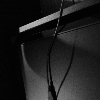

Classifying as paper
Paper Confidence: 99.73164191447307 %
Rock Confidence: 0.13884019450206903 %
Scissors Confidence: 0.1295178910248367 %

It looks like you played paper but please confirm this by typing Rock (r), Paper (p), or Scissors (s)
Scissors sounds good to me!

I predicted you would play paper so I played scissors

Well, that was boring, but it was a tie. re-run the cell to play again.


In [87]:
# Load the CSV file
df_history = load_game_history()

# Instructions
display_instructions()

# Generate a prediction before the player makes their move
# Note: This will retrain the model every time off of the latest data
predicted_move = predict_move(df_history)

# Countdown and get the player's move image from their webcam
countdown(3)
player_img = get_image_from_camera()

# Analyze the image and classify it to a player move
print()
# Hiding since it was just too much height since classify shows a small image anyway: display_image(player_img)
move = classify_image(player_img)

# Confirm move with player. This is a safety net for poorly fit models or models that do not perform well against the actual camera environment
move = confirm_and_correct_move(move)

# Store the move and recent history in the CSV file for future training
store_player_move(move, df_history, t_minus_1_move, t_minus_1_winner, t_minus_2_move, t_minus_2_winner)

# Display the predicted move
print()
ai_move = get_opposing_move(predicted_move)
print('I predicted you would play', predicted_move, 'so I played', ai_move)

# Display the game result
print()
winner = determine_winner(move, ai_move)
display_game_result_message(winner)

# Rotate the history so the next game is accurate
t_minus_2_move, t_minus_2_winner, t_minus_1_move, t_minus_1_winner = rotate_history(move, winner, t_minus_1_move, t_minus_1_winner, t_minus_2_move, t_minus_2_winner)

In [77]:
t_minus_2_move, t_minus_2_winner, t_minus_1_move, t_minus_1_winner

('rock', 'tie', 'rock', 'player')

## Exploring Game Trends